In [ ]:
!pip install timm torch torchvision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/KNI Own Materials/Research Materials/Blind People/Vision Research /BD Coin [Classification]"   # change to your dataset folder

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm
from tqdm import tqdm   # progress bar
from PIL import Image

device = "cpu"
print("Running on:", device)


Running on: cpu


In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
train_data = ImageFolder(f"{DATASET_PATH}/train", transform=transform_train)
val_data   = ImageFolder(f"{DATASET_PATH}/valid", transform=transform_val)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)  # small batch size for CPU
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False)

num_classes = len(train_data.classes)

print("Classes:", train_data.classes)
print("Train images:", len(train_data))
print("Val images:", len(val_data))


Classes: ['1b', '1f', '2b', '2f', '5b', '5f']
Train images: 5843
Val images: 1708


In [ ]:
model = timm.create_model("deit_tiny_patch16_224", pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Completed | Loss: {total_loss:.4f}")


Epoch 1 Completed | Loss: 295.4037


Epoch 2 Completed | Loss: 134.1114


Epoch 3 Completed | Loss: 97.1132


Epoch 4 Completed | Loss: 66.0315


Epoch 5 Completed | Loss: 59.7363


Epoch 6 Completed | Loss: 46.7624


Epoch 7 Completed | Loss: 43.3970


Epoch 8 Completed | Loss: 47.0156


Epoch 9 Completed | Loss: 37.9381


Epoch 10 Completed | Loss: 34.4001


In [ ]:
def evaluate_accuracy(dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

final_train_acc = evaluate_accuracy(train_loader)
print(f"Final Training Accuracy: {final_train_acc:.2f}%")


Final Training Accuracy: 98.13%


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {correct / total * 100:.2f}%")


Validation Accuracy: 90.40%


In [ ]:
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform_val(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)

    return train_data.classes[pred.item()]

# Example usage
#print(predict_image("/content/sample_coin.jpg"))


In [ ]:
torch.save(model.state_dict(), "deit_cpu_coin_classifier.pth")


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Define transform (same as training)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load test dataset
test_data = ImageFolder(f"{DATASET_PATH}/test", transform=transform_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print("Test classes:", test_data.classes)
print("Number of test images:", len(test_data))


Test classes: ['1b', '1f', '2b', '2f', '5b', '5f']
Number of test images: 1718


In [ ]:
model.eval()  # make sure the model is in evaluation mode

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 91.97%


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_data.classes))


Classification Report:
              precision    recall  f1-score   support

          1b       0.56      0.99      0.71       100
          1f       0.92      0.93      0.92       130
          2b       0.91      0.94      0.93       100
          2f       0.89      0.97      0.93       265
          5b       0.96      1.00      0.98       100
          5f       1.00      0.89      0.94      1023

    accuracy                           0.92      1718
   macro avg       0.87      0.95      0.90      1718
weighted avg       0.94      0.92      0.92      1718



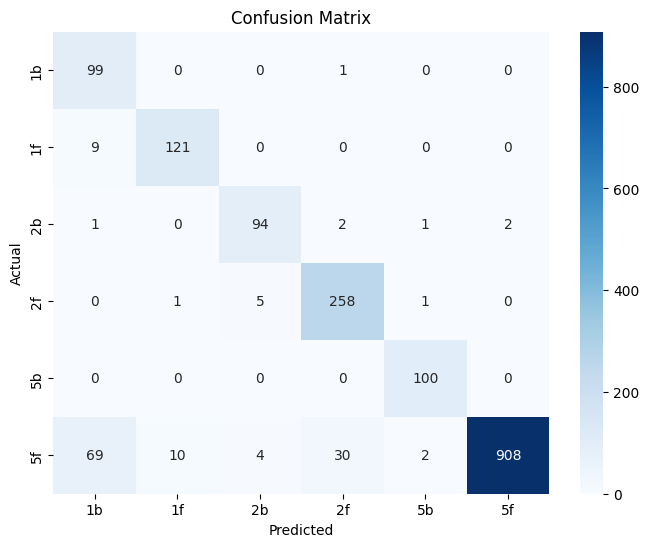

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_data.classes, yticklabels=test_data.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
